In [713]:
# Declaración de librerías
import nltk
import numpy
import tensorflow
import random
import json
import locale
import platform
from datetime import datetime

# Configurar el locale en español
if platform.system() == 'Linux':
    locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')
elif platform.system() == 'Windows':
    locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

In [714]:
# Lectura de formatos .json para entrenar cada modelo y asignación
# de información correspondiente
with open('Intenciones_NivelI.json', encoding='utf-8') as file:
    data_NivelI = json.load(file)
    
with open('Intenciones_NivelIIA.json', encoding='utf-8') as file:
    data_NivelIIA = json.load(file)
    
with open('Intenciones_NivelIIB.json', encoding='utf-8') as file:
    data_NivelIIB = json.load(file)

In [715]:
# Creación de diccionarios con los nombres de las clases y textos
# presentes en cada uno de los archivos
NI = dict()
NIIA = dict()
NIIB = dict()

for info in data_NivelI['intents']:
    NI.setdefault(info['tag'], info['patterns'])

for info in data_NivelIIA['intents']:
    NIIA.setdefault(info['tag'], info['patterns'])
    
for info in data_NivelIIB['intents']:
    NIIB.setdefault(info['tag'], info['patterns'])
        
print(NI)
print(NIIA)
print(NIIB)

{'Reservar_Habitacion': ['Quiero hacer una reserva', 'Quiero reservar una habitación', 'Me gustaría reservar una habitación', '¿Puedo reservar una habitación?', 'Por favor reserva una habitación', 'Quiero reservar un cuarto', 'Me gustaría reservar un cuarto', 'Por favor reserva un cuarto', '¿Puedo reservar un cuarto?', 'Apartar un cuarto', 'Apartar una habitación'], 'Servicio_hotel': ['Quiero pedir un servicio', 'Quiero solicitar un servicio', 'Necesito solicitar un servicio', 'Quiero pedir un servicio del hotel', 'Necesito un servicio del hotel', 'Me gustaría pedir un servicio', 'Me gustaría solicitar un servicio', 'Quiero pedir servicio al cuarto', 'Me gustaría solicitar servicio al cuarto', 'Quiero pedir servicio a la habitación', 'Room service', 'Quiero pedir comida', 'Quiero apartar un espacio'], 'Historia_Hotel': ['Cuéntame la historia del hotel', 'Háblame del pasado del hotel', '¿Qué historias tiene este hotel?', '¿Qué anécdotas hay del hotel?', 'Me interesa la historia del hote

In [716]:
# Generamos los vectores de respuestas para cada nivel contextual
# (Cada clase tiene una salida numérica asociada)
# (Las salidas empiezan en 0 para cada clase inicial de cada modelo)
Y_NI = list()
Y_NIIA = list()
Y_NIIB = list()

for clase, lista_textos in NI.items():
    for text in lista_textos:
        Y_NI.append(list(NI.keys()).index(clase))
        
for clase, lista_textos in NIIA.items():
    for text in lista_textos:
        Y_NIIA.append(list(NIIA.keys()).index(clase))
        
for clase, lista_textos in NIIB.items():
    for text in lista_textos:
        Y_NIIB.append(list(NIIB.keys()).index(clase))
    
print("Vector de salidas Y para N1:")
print(Y_NI)
print("Vector de salidas Y para N2A:")
print(Y_NIIA)
print("Vector de salidas Y para N2B:")
print(Y_NIIB)

Vector de salidas Y para N1:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Vector de salidas Y para N2A:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Vector de salidas Y para N2B:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [717]:
# Importamos librerías para el filtrado de StopWords y tokenicación
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import re

stop_words = set(stopwords.words('spanish'))

In [718]:
# Para cada enunciado quitamos las StopWords
# También quitamos los acentos y filtramos signos de puntuación
# lo hacemos mediante un metodo
def Quitar_Stopwords(Textos):
    X = list()
    for sen in Textos:
        sentence = sen
        # Filtrado de stopword
        for stopword in stop_words:
            sentence = sentence.replace(" " + stopword + " ", " ")
        sentence = sentence.replace("á", "a")
        sentence = sentence.replace("é", "e")
        sentence = sentence.replace("í", "i")
        sentence = sentence.replace("ó", "o")
        sentence = sentence.replace("ú", "u")

        # Remover espacios múltiples
        sentence = re.sub(r'\s+', ' ', sentence)
        # Convertir todo a minúsculas
        sentence = sentence.lower()
        # Filtrado de signos de puntuación
        tokenizer = RegexpTokenizer(r'\w+')
        # Tokenización del resultado
        result = tokenizer.tokenize(sentence)
        # Agregar al arreglo los textos "destokenizados" (Como texto nuevamente)
        X.append(TreebankWordDetokenizer().detokenize(result))
    return X

In [719]:
# Obtenemos el vector de entradas (Textos limpios de StopWords)
# para cada uno de los modelos que vamos a generar
Textos_NI = list()
for Lista in NI.values():
    for Texto in Lista:
        Textos_NI.append(Texto)
        
X_NI = Quitar_Stopwords(Textos_NI)

Textos_NIIA = list()
for Lista in NIIA.values():
    for Texto in Lista:
        Textos_NIIA.append(Texto)
        
X_NIIA = Quitar_Stopwords(Textos_NIIA)

Textos_NIIB = list()
for Lista in NIIB.values():
    for Texto in Lista:
        Textos_NIIB.append(Texto)
        
X_NIIB = Quitar_Stopwords(Textos_NIIB)

In [720]:
# Imprimimos la lista de los enunciados que resultan
print(X_NI)
print(X_NIIA)
print(X_NIIB)

['quiero hacer reserva', 'quiero reservar habitacion', 'me gustaria reservar habitacion', 'puedo reservar habitacion', 'por favor reserva habitacion', 'quiero reservar cuarto', 'me gustaria reservar cuarto', 'por favor reserva cuarto', 'puedo reservar cuarto', 'apartar cuarto', 'apartar habitacion', 'quiero pedir servicio', 'quiero solicitar servicio', 'necesito solicitar servicio', 'quiero pedir servicio hotel', 'necesito servicio hotel', 'me gustaria pedir servicio', 'me gustaria solicitar servicio', 'quiero pedir servicio cuarto', 'me gustaria solicitar servicio cuarto', 'quiero pedir servicio habitacion', 'room service', 'quiero pedir comida', 'quiero apartar espacio', 'cuentame historia hotel', 'hablame pasado hotel', 'que historias hotel', 'que anecdotas hotel', 'me interesa historia hotel', 'que hace unico hotel historicamente', 'este hotel parte historia ciudad', 'que pasado hotel largo años', 'este lugar alguna historia especial', 'me encantaria conocer herencia cultural hotel

In [721]:
# Importamos la librería para generar la matriz de entrada de textos
# (El pad_sequence)
from keras_preprocessing.sequence import pad_sequences

# Cantidad de palabras máximas por ejemplo
# (Las más utilizadas)
maxlen = 5

# Preparamos la capa de embeddingsn(Predefinimos una cantidad de
# 5000 palabras consideradas como tokens
tokenizer_NI = Tokenizer(num_words=5000)
tokenizer_NIIA = Tokenizer(num_words=5000)
tokenizer_NIIB = Tokenizer(num_words=5000)

# Transforma cada texto en una secuencia de valores enteros para cada modelo que haremos
tokenizer_NI.fit_on_texts(X_NI)
X_NI_Tok = tokenizer_NI.texts_to_sequences(X_NI)
tokenizer_NIIA.fit_on_texts(X_NIIA)
X_NIIA_Tok = tokenizer_NIIA.texts_to_sequences(X_NIIA)
tokenizer_NIIB.fit_on_texts(X_NIIB)
X_NIIB_Tok = tokenizer_NIIB.texts_to_sequences(X_NIIB)

# Especificamos la matriz (Con padding hasta maxlen)
X_NI_train = pad_sequences(X_NI_Tok, padding='post', maxlen=maxlen)
X_NIIA_train = pad_sequences(X_NIIA_Tok, padding='post', maxlen=maxlen)
X_NIIB_train = pad_sequences(X_NIIB_Tok, padding='post', maxlen=maxlen)


In [722]:
print("Matriz de entrada para NI:")
print(X_NI_train)

Matriz de entrada para NI:
[[  3  17  18   0   0]
 [  3   8   9   0   0]
 [  4   6   8   9   0]
 [ 10   8   9   0   0]
 [ 26  27  18   9   0]
 [  3   8   7   0   0]
 [  4   6   8   7   0]
 [ 26  27  18   7   0]
 [ 10   8   7   0   0]
 [ 19   7   0   0   0]
 [ 19   9   0   0   0]
 [  3  11   5   0   0]
 [  3  16   5   0   0]
 [ 28  16   5   0   0]
 [  3  11   5   1   0]
 [ 28   5   1   0   0]
 [  4   6  11   5   0]
 [  4   6  16   5   0]
 [  3  11   5   7   0]
 [  4   6  16   5   7]
 [  3  11   5   9   0]
 [ 45  46   0   0   0]
 [  3  11  47   0   0]
 [  3  19  48   0   0]
 [ 29  12   1   0   0]
 [ 49  30   1   0   0]
 [  2  50   1   0   0]
 [  2  51   1   0   0]
 [  4  31  12   1   0]
 [  2  52  53   1  54]
 [ 32   1  55  12  56]
 [  2  30   1  57  58]
 [ 32  59  20  12  60]
 [ 61  33  62  63   1]
 [ 65  21  66  67   1]
 [ 22  68  34  69   1]
 [ 35  20  70  71   1]
 [  4   6  34  72   1]
 [ 21  74  36  75   1]
 [ 22  76  77   1   0]
 [  2  78  79  80   1]
 [ 81  82  36  83   0]
 [ 84  

In [723]:
print("Matriz de entrada para NIIA:")
print(X_NIIA_train)

Matriz de entrada para NIIA:
[[41  5 14  0  0]
 [42 43  0  0  0]
 [15 16 17  5 18]
 [19  5 20  0  0]
 [44 45  5 46  0]
 [ 1  5 11 21  0]
 [22 23 47 24  0]
 [25  5 48  0  0]
 [ 1  6 14  0  0]
 [15 16 17  6 18]
 [19  6 20  0  0]
 [ 1  6 11 21  0]
 [22 23 49 24  0]
 [ 1  6 50 51  0]
 [25  6 52  0  0]
 [ 1 53  0  0  0]
 [ 7  4 12  0  0]
 [ 7  4 26 12  0]
 [ 1  4 27  0  0]
 [ 1  4 28  0  0]
 [ 1  4 29  0  0]
 [ 1  4 30  0  0]
 [ 1  4 31  0  0]
 [ 1  4 32  0  0]
 [ 1  4 33  0  0]
 [ 7  3 12  0  0]
 [ 7  3 26 12  0]
 [ 7  3 34 54  0]
 [ 7  3 34 55  0]
 [ 1  3 27  0  0]
 [ 1  3 28  0  0]
 [ 1  3 29  0  0]
 [ 1  3 30  0  0]
 [ 1  3 31  0  0]
 [ 1  3 32  0  0]
 [ 1  3 33  0  0]
 [13 35  0  0  0]
 [13 35  0  0  0]
 [56 13  0  0  0]
 [ 8 36  2  0  0]
 [ 8 37  2  0  0]
 [ 8 38  2  0  0]
 [ 9 10 36  2  0]
 [ 9 10 37  2  0]
 [ 9 10 38  2  0]
 [ 8 11  2  0  0]
 [ 8 39  2  0  0]
 [ 8 40  2  0  0]
 [ 9 10 11  2  0]
 [ 9 10 39  2  0]
 [ 9 10 40  2  0]]


In [724]:
print("Matriz de entrada para NIIB:")
print(X_NIIB_train)

Matriz de entrada para NIIB:
[[ 1  8 12  0  0]
 [ 4  5 18  0  0]
 [13 14  8 19 20]
 [13 14  5 21  0]
 [ 1  5 22  0  0]
 [ 1  5 12  0  0]
 [ 1  8 15  0  0]
 [ 1  5 15  0  0]
 [ 4 23  2  6  0]
 [ 4 24  7  6  0]
 [25 26  2  0  0]
 [16  6 27 28  2]
 [ 4  3 29  0  0]
 [ 4  3 30  0  0]
 [ 4 31 32  0  0]
 [ 1  3 33  0  0]
 [ 1  9 10  7  0]
 [16  6  3 34  2]
 [ 1 17 35 36  7]
 [ 3 10 37  2  0]
 [ 1  9 10 38  0]
 [ 1 17 39  2  0]
 [ 3 11 40  2  0]
 [ 1  9 11  2  0]
 [ 3 11  7  0  0]]


In [725]:
# Declaración de librerías para manejo de arreglos (Numpy)
from numpy import asarray
from numpy import zeros

# Lectura del archivo de embeddings
embeddings_dictionary = dict()
Embeddings_file = open('/Users/mascenci/Desktop/Chatbots/Word2Vect_Spanish.txt', encoding="utf8")

# Extraemos las características del archivo de embeddings
# y las agregamos a un diccionario (Cada elemento es un vextor)
for linea in Embeddings_file:
    caracts = linea.split()
    palabra = caracts[0]
    vector = asarray(caracts[1:], dtype='float32')
    embeddings_dictionary [palabra] = vector
Embeddings_file.close()

In [726]:
# Asignamos los embeddings correspondientes a cada matriz 
# con la que se entrenarán los modelos por medio de un método
def Asignar_Embeddings(tokenizer, vocab_size):
    # Generamos la matriz de embeddings (Con 300 Características)
    embedding_matrix = zeros((vocab_size, 300))
    for word, index in tokenizer.word_index.items():
        # Extraemos el vector de embedding para cada palabra
        embedding_vector = embeddings_dictionary.get(word)
        # Si la palbra si existía en el vocabulario
        # agregamos su vector de embeddings en la matriz
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [727]:
# Obtenemos las matrices de Embeddings para cada modelo
# Y también el tamaño del vocabulario para cada uno
vocab_size_NI = len(tokenizer_NI.word_index) + 1
embedding_matrix_NI = Asignar_Embeddings(tokenizer_NI, vocab_size_NI)

vocab_size_NIIA = len(tokenizer_NIIA.word_index) + 1
embedding_matrix_NIIA = Asignar_Embeddings(tokenizer_NIIA, vocab_size_NIIA)

vocab_size_NIIB = len(tokenizer_NIIB.word_index) + 1
embedding_matrix_NIIB = Asignar_Embeddings(tokenizer_NIIB, vocab_size_NIIB)

In [728]:
# Declaración de modelo Secuencial que usaremos para todos los casos
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [729]:
# Definición del método para tener la arquitectura de los modelos para cada nivel contextual
def Definir_Modelos(vocab_size, embedding_matrix, X_train, labels):
    # Declaración de las capas del modelo LSTM
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=X_train.shape[1] , trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(labels), activation='softmax'))

    # Compilación del modelo
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    print("\nPalabras en el vocabulario:")
    print(vocab_size)
    return model

In [730]:
# Generamos la arquitectura para el modelo de NI
model_NI = Definir_Modelos(vocab_size_NI, embedding_matrix_NI, X_NI_train, NI.keys())

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 5, 300)            36000     
                                                                 
 lstm_42 (LSTM)              (None, 100)               160400    
                                                                 
 dense_42 (Dense)            (None, 4)                 404       
                                                                 
Total params: 196,804
Trainable params: 160,804
Non-trainable params: 36,000
_________________________________________________________________
None

Palabras en el vocabulario:
120


In [731]:
# Generamos la arquitectura para el modelo de NIIA
model_NIIA = Definir_Modelos(vocab_size_NIIA, embedding_matrix_NIIA, X_NIIA_train, NIIA.keys())

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 5, 300)            17100     
                                                                 
 lstm_43 (LSTM)              (None, 100)               160400    
                                                                 
 dense_43 (Dense)            (None, 4)                 404       
                                                                 
Total params: 177,904
Trainable params: 160,804
Non-trainable params: 17,100
_________________________________________________________________
None

Palabras en el vocabulario:
57


In [732]:
# Generamos la arquitectura para el modelo de NIIB
model_NIIB = Definir_Modelos(vocab_size_NIIB, embedding_matrix_NIIB, X_NIIB_train, NIIB.keys())

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 5, 300)            12300     
                                                                 
 lstm_44 (LSTM)              (None, 100)               160400    
                                                                 
 dense_44 (Dense)            (None, 3)                 303       
                                                                 
Total params: 173,003
Trainable params: 160,703
Non-trainable params: 12,300
_________________________________________________________________
None

Palabras en el vocabulario:
41


In [733]:
# Declaramos el método para entrenar cada modelo
from keras.utils.np_utils import to_categorical 

def Entrenar_Modelos(X_train, Y, model, labels):
    # Declaramos librería para convertir la salida en un vector 
    # de X elementos con activación en la columna correspondiente
    # a su categoría
    train_labels = to_categorical(Y, num_classes=len(labels))
    print('Matriz de salidas')
    print(train_labels)

    # Ajuste de los datos de entrenamiento al modelo creado
    history = model.fit(X_train, train_labels, epochs=30, batch_size=1, verbose=1)

    # Cálculo de los procentajes de Eficiencia y pérdida 
    score = model.evaluate(X_train, train_labels, verbose=1)
    print("\nTest Loss:", score[0])
    print("Test Accuracy:", score[1])
    return history

In [734]:
# Entrenamos el modelo del nivel NI y obtenemos el historial de las épocas para realizar su gráfica
history_NI = Entrenar_Modelos(X_NI_train, Y_NI, model_NI, NI.keys())

Matriz de salidas
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Epoch 1/30
63/63 [==================

In [735]:
# Entrenamos el modelo del nivel NIIA y obtenemos el historial de las épocas para realizar su gráfica
history_NIIA = Entrenar_Modelos(X_NIIA_train, Y_NIIA, model_NIIA, NIIA.keys())

Matriz de salidas
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Epoch 1/30
51/51 [==============================] - 1s 2ms/step - loss: 1.3288 - accuracy: 0.4902
Epoch 2/30
51/51 [==============================] - 0s 3ms/step - loss: 0.7622 - accuracy: 0.8627
Epoch 3/30
51/51 [==

In [736]:
# Entrenamos el modelo del nivel NIIB y obtenemos el historial de las épocas para realizar su gráfica
history_NIIB = Entrenar_Modelos(X_NIIB_train, Y_NIIB, model_NIIB, NIIB.keys())

Matriz de salidas
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Epoch 1/30
25/25 [==============================] - 1s 2ms/step - loss: 1.0878 - accuracy: 0.3200
Epoch 2/30
25/25 [==============================] - 0s 3ms/step - loss: 0.9714 - accuracy: 0.7600
Epoch 3/30
25/25 [==============================] - 0s 3ms/step - loss: 0.7547 - accuracy: 0.9200
Epoch 4/30
25/25 [==============================] - 0s 3ms/step - loss: 0.2980 - accuracy: 0.9600
Epoch 5/30
25/25 [==============================] - 0s 3ms/step - loss: 0.1257 - accuracy: 0.9600
Epoch 6/30
25/25 [==============================] - 0s 3ms/step - loss: 0.1025 - accuracy: 0.9600
Epoch 7/30
25/25 [==============================] - 0s 3ms/step - loss: 0.0171 - accuracy: 1.

In [737]:
# Método para hacer la gráfica de cada modelo
# época a época para ver su evolución
import matplotlib.pyplot as plt

def Grafica_Modelo(history):
    # Parámetros de ploteo para la gráfica
    plt.figure(figsize=(12,5))
    plt.ylim(-0.1, 1.1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Acc','Loss'])
    plt.show()

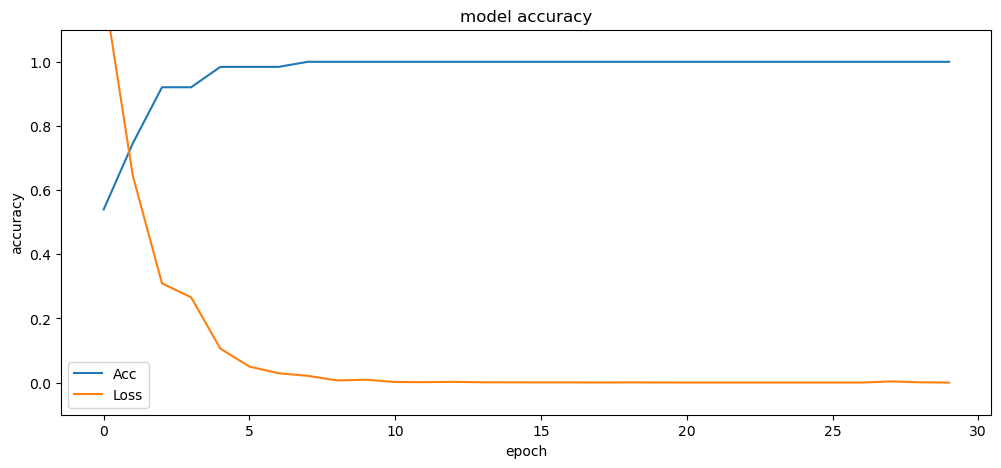

In [738]:
# Graficar el modelo NI
Grafica_Modelo(history_NI)

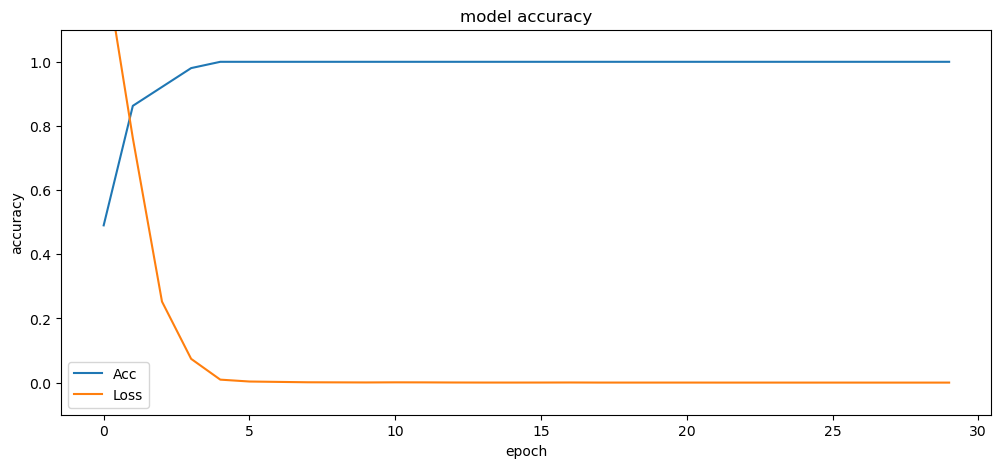

In [739]:
# Graficar el modelo NIIA
Grafica_Modelo(history_NIIA)

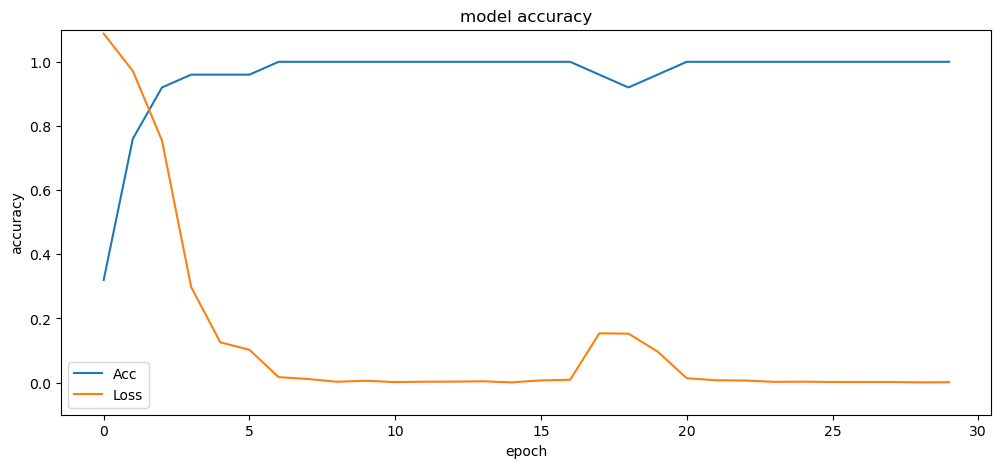

In [740]:
# Graficar el modelo NIIB
Grafica_Modelo(history_NIIB)

# Programación del Árbol conversacional

In [741]:
# El árbol conversacional debe de estar en un estado específico
# iniciar en el nivel contextual 1, e ir avanzando conforme a
# las decisiones que toma el usuario, como si fuera una máquina 
# de estados

def instancer(inp, model, tags):
    inp = inp.lower().replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o")
    inp = inp.replace("ú", "u").replace("¿", "").replace("?", "")
    txt = [inp]
    seq = tokenizer_NI.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=maxlen)

    # Add these print statements to debug
    print("Input shape before predict:", padded.shape)
    print("Input data:", padded)

    results = model.predict(padded)
    results_index = numpy.argmax(results)
    tag = list(tags.keys())[results_index]
    maxscore = numpy.max(results)
    return tag, maxscore
    

In [742]:
# Función del Nivel contextual 1:
def Activar_NI():
    # Pregunta inicial cuando se ingresa en el nivel contextual NI
    print("\nChatBot: ¿En qué puedo ayudarte?\n")    
    
    while True:
        inp = input("     Tú: ")
        tag, maxscore = instancer(inp, model_NI, NI)
        
        if maxscore > 0.8 or inp == 'salir':
            break
        else:
            print("\nChatBot: Lo siento, pero no entendí tu petición, ¿Podrías decirlo de otra forma?\n")
    
    if inp == 'salir':
        print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
        return 'salir'
    
    if tag == 'Reservar_Habitacion':
        if inp.count('Tipo_Habitacion') > 0:
            return 'NIIA1'
        elif inp.count('Fecha_entrada') > 0:
            return 'NIIA2'
        elif inp.count('Fecha_salida') > 0:
            return 'NIIA3'
        elif inp.count("Num_huespedes") > 0:
            return 'NIIA4'
        else:
            return 'NIIA'
    
    if tag == 'Servicio_hotel':
         if inp.count('Apartar_espacio') > 0:
             return 'NIIB1'
         elif inp.count('Servicio') > 0:
             return 'NIIB2'
         elif inp.count('Comida_bebida') > 0:
             return 'NIIB3'
         else:
             return 'NIIB'
         
    if tag == 'Historia_Hotel':
        print("\nChatBot: Desde su apertura en 1920 por el pionero Don Eduardo Mendoza, nuestro hotel es un ícono de la arquitectura Art Deco, diseñado por Carlos Fontana.\nHa acogido a luminarias como la actriz Clara Estrella en los años 30 y fue el lugar de la histórica cumbre de paz en 1955. Cada habitación cuenta una historia; por ejemplo, la suite 204, donde el novelista Luis Montero escribió su obra maestra. Es un lugar donde la historia y la hospitalidad se encuentran en cada esquina.\n")
        return 'NI'
    
    if tag == 'Atracciones_Cercanas':
        print("\nChatbot: En el corazón de la ciudad, nuestro hotel se encuentra a un corto trayecto del Parque Central y a unos minutos del Museo Nacional de Arte, perfecto para los entusiastas de la cultura. Para aquellos interesados en la historia, el Convento de San Francisco está a una caminata de distancia. No te pierdas el Mercado del Sol, ideal para saborear la cocina local y encontrar artesanías únicas. Además, ofrecemos excursiones al Castillo de San Lorenzo, un sitio histórico con vistas espectaculares, a solo media hora en coche.\n")
        return 'NI'

In [743]:
# Función del Nivel contextual IIA:
def Activar_NIIA():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA
    print("\nChatBot: Entiendo que quieres reservar una habitación, por favor repite \"Reservar Habitación\" para iniciar el proceso\n")  

    global Tipo_Cuarto
    global Fecha_entrada
    global Fecha_salida
    global Num_huespedes
    
    while True:
        inp = input("     Tú: ")
        tag, maxscore = instancer(inp, model_NIIA, NIIA)
        
        if maxscore > 0.5 or inp == 'salir' or inp == 'volver':
            break
        else:
            print("\nChatBot: Lo siento, pero no entendí. Puedes decirme \"Reservar Habitación\" por ejemplo.\n")
    
    if inp == 'volver':
        return 'NI'
    
    if inp == 'salir':
        print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
        return 'salir'
    
    if tag == 'Tipo_Habitacion' or Tipo_Cuarto == "":
        return 'NIIA1'
    
    if tag == 'Fecha_entrada':
        return 'NIIA2'
    
    if tag == 'Fecha_salida':
        return 'NIIA3'
    
    if tag == 'Num_huespedes':
        return 'NIIA4'

In [744]:
# Función del Nivel contextual IIA1:
def Activar_NIIA1():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA1

    global Tipo_Cuarto

    print("\nChatBot: Excelente! Reservemos una habitación. ¿Qué tipo de habitación te gustaría reservar?\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp.count('estándar') > 0:
            print("\nChatBot: Excelente, reservaremos una habitación estándar.\n")
            Tipo_Cuarto = "Estándar"
            return 'NIIA2'
        elif inp.count('suite') > 0:
            print("\nChatBot: Excelente, reservaremos una habitación suite.\n")
            Tipo_Cuarto = "Suite"
            return 'NIIA2'
        elif inp.count('doble') > 0:
            print("\nChatBot: Excelente, reservaremos una habitación doble.\n")
            Tipo_Cuarto = "Doble"
            return 'NIIA2'
        elif inp.count('familiar') > 0:
            print("\nChatBot: Excelente, reservaremos una habitación familiar.\n")
            Tipo_Cuarto = "Familiar"
            return 'NIIA2'
        elif inp.count('deluxe') > 0:
            print("\nChatBot: Excelente, reservaremos una habitación deluxe.\n")
            Tipo_Cuarto = "Deluxe"
            return 'NIIA2'
        elif inp.count('dos camas') > 0:
            print("\nChatBot: Excelente, reservaremos una habitación doble.\n")
            Tipo_Cuarto = "Doble"
            return 'NIIA2'
        elif inp.count('ofrecen') > 0:
            print("\nChatBot: Ofrecemos los siguientes tipos de habitaciones: estándar, doble, familiar, suite, y deluxe.\n")
            return 'NIIA2'
        elif inp.count('económica') > 0:
            print("\nChatBot: Excelente, reservaremos una habitación estándar.\n")
            Tipo_Cuarto = "Estándar"
            return 'NIIA2'
        else:
            print("\nChatBot: ¿Podrías repetirme qué tipo de habitación te gustaría reservar?\n")

In [745]:
def Activar_NIIA2():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA2

    global Fecha_entrada

    print("\nChatBot: Muy bien! ¿Para cuándo agendamos su entrada? (dd/mm/aaaa)\n")

    while True:
        inp = input("     Tú: ").lower()

        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        else:
            # Intenta convertir la entrada en una fecha
            try:
                # Asume que la entrada está en formato dd/mm/aaaa
                fecha_entrada = datetime.strptime(inp, '%d/%m/%Y')
                # Comprueba que la fecha no sea pasada
                if fecha_entrada.date() < datetime.now().date():
                    print("\nChatBot: No puedes agendar una fecha en el pasado. Por favor, elige una fecha futura.\n")
                else:
                    fecha_formateada = fecha_entrada.strftime('%d de %B del %Y')
                    print("\nChatBot: Muy bien, agendaré la entrada para el {}.\n".format(fecha_formateada))
                    Fecha_entrada = fecha_entrada
                    return 'NIIA3'
            except ValueError:
                # Si hay un error en la conversión, indica que el formato no es correcto
                print("\nChatBot: Parece que la fecha no está en el formato correcto. Por favor, ingresa la fecha en formato dd/mm/aaaa.\n")



In [746]:
# Función del Nivel contextual IIA3:
def Activar_NIIA3():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA3

    global Fecha_salida
    global Fecha_entrada

    print("\nChatBot: Muy bien! ¿Para cuándo agendamos su salida? (dd/mm/aaaa)\n")

    while True:
        inp = input("     Tú: ").lower()

        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        else:
            # Intenta convertir la entrada en una fecha
            try:
                # Asume que la entrada está en formato dd/mm/aaaa
                fecha_salida = datetime.strptime(inp, '%d/%m/%Y')
                # Comprueba que la fecha no sea pasada y que sea después de la fecha de entrada
                if fecha_salida.date() < datetime.now().date():
                    print("\nChatBot: No puedes agendar una fecha de salida en el pasado. Por favor, elige una fecha futura.\n")
                elif fecha_salida.date() <= Fecha_entrada.date():
                    print("\nChatBot: La fecha de salida debe ser posterior a la fecha de entrada. Por favor, elige una fecha adecuada.\n")
                else:
                    fecha_formateada = fecha_salida.strftime('%d de %B del %Y')
                    print("\nChatBot: Muy bien, agendaré la salida para el {}.\n".format(fecha_formateada))
                    Fecha_salida = fecha_salida
                    return 'NIIA4'
            except ValueError:
                # Si hay un error en la conversión, indica que el formato no es correcto
                print("\nChatBot: Parece que la fecha no está en el formato correcto. Por favor, ingresa la fecha en formato dd/mm/aaaa.\n")

In [747]:
# Función del Nivel contextual IIA4:
def Activar_NIIA4():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA4

    global Num_huespedes

    print("\nChatBot: Súper! ¿Para cuántas personas es la reservación?\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp.count('yo') > 0:
            print("\nChatBot: Muy bien, agendaré para una sola persona.\n")
            Num_huespedes = 1
            print("La reservación final es de ", Num_huespedes, " personas con el tipo de cuarto ", Tipo_Cuarto, " con fecha de entrada ", Fecha_entrada, " y fecha de salida ", Fecha_salida, ". \n\n Si desdeas algo más no dudes en preguntar.")
            return 'NI'
        elif inp.count('solo') > 0:
            print("\nChatBot: Muy bien, agendaré para una sola persona.\n")
            Num_huespedes = 1
            print("La reservación final es de ", Num_huespedes, " personas con el tipo de cuarto ", Tipo_Cuarto, " con fecha de entrada ", Fecha_entrada, " y fecha de salida ", Fecha_salida, ". \n\n Si desdeas algo más no dudes en preguntar.")
            return 'NI'
        elif inp.count('2') > 0:
            print("\nChatBot: Muy bien, agendaré para dos personas.\n")
            Num_huespedes = 2
            print("La reservación final es de ", Num_huespedes, " personas con el tipo de cuarto ", Tipo_Cuarto, " con fecha de entrada ", Fecha_entrada, " y fecha de salida ", Fecha_salida, ". \n\n Si desdeas algo más no dudes en preguntar.")
            return 'NI'
        elif inp.count('dos') > 0:
            print("\nChatBot: Muy bien, agendaré para dos personas.\n")
            Num_huespedes = 2
            print("La reservación final es de ", Num_huespedes, " personas con el tipo de cuarto ", Tipo_Cuarto, " con fecha de entrada ", Fecha_entrada, " y fecha de salida ", Fecha_salida, ". \n\n Si desdeas algo más no dudes en preguntar.")
            return 'NI'
        elif inp.count('3') > 0:
            print("\nChatBot: Muy bien, agendaré para tres personas.\n")
            Num_huespedes = 3
            print("La reservación final es de ", Num_huespedes, " personas con el tipo de cuarto ", Tipo_Cuarto, " con fecha de entrada ", Fecha_entrada, " y fecha de salida ", Fecha_salida, ". \n\n Si desdeas algo más no dudes en preguntar.")
            return 'NI'
        elif inp.count('tres') > 0:
            print("\nChatBot: Muy bien, agendaré para tres personas.\n")
            Num_huespedes = 3
            print("La reservación final es de ", Num_huespedes, " personas con el tipo de cuarto ", Tipo_Cuarto, " con fecha de entrada ", Fecha_entrada, " y fecha de salida ", Fecha_salida, ". \n\n Si desdeas algo más no dudes en preguntar.")
            return 'NI'
        elif inp.count('4') > 0:
            print("\nChatBot: Muy bien, agendaré para cuatro personas.\n")
            Num_huespedes = 4
            print("La reservación final es de ", Num_huespedes, " personas con el tipo de cuarto ", Tipo_Cuarto, " con fecha de entrada ", Fecha_entrada, " y fecha de salida ", Fecha_salida, ". \n\n Si desdeas algo más no dudes en preguntar.")
            return 'salir'
        elif inp.count('cuatro') > 0:
            print("\nChatBot: Muy bien, agendaré para cuatro personas.\n")
            Num_huespedes = 4
            print("La reservación final es de ", Num_huespedes, " personas con el tipo de cuarto ", Tipo_Cuarto, " con fecha de entrada ", Fecha_entrada, " y fecha de salida ", Fecha_salida, ". \n\n Si desdeas algo más no dudes en preguntar.")
            return 'NI'
            
        
        else:
            print("\nChatBot: ¿Podrías repetirme para cuántas personas es la reservación?\n")

In [748]:
# Función del Nivel contextual IIB:
def Activar_NIIB():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIB
    print("\nChatBot: Entiendo que quieres pedir un servicio del Hotel. (Apartar espacio, Perdir servicio al cuarto, Pedir comida o bebida)\n")  
    
    while True:
        inp = input("     Tú: ")
        tag, maxscore = instancer(inp, model_NIIB, NIIB)

        print(model_NIIB.summary())

        if maxscore > 0.5 or inp == 'salir' or inp == 'volver':
            break
        else:
            print("\nChatBot: Lo siento, pero no entendí. Puedes decirme \"Apartar espacio\" por ejemplo.\n")
    
    if inp == 'volver':
        return 'NI'
    
    if inp == 'salir':
        print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
        return 'salir'
    
    if tag == 'Apartar_espacio':
        return 'NIIB1'
    
    if tag == 'Servicio':
        return 'NIIB2'
    
    if tag == 'Comida_bebida':
        return 'NIIB3'

In [749]:
# Función del Nivel contextual IIB1:
def Activar_NIIB1():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIB1

    global Espacio_Apartado

    print("\nChatBot: Excelente! Apartemos un espacio. ¿Qué tipo de espacio te gustaría reservar?\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp.count('alberca') > 0:
            print("\nChatBot: Excelente, reservaremos la alberca. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Espacio_Apartado = "alberca"
            return 'NIIA2'
        elif inp.count('gimnasio') > 0:
            print("\nChatBot: Excelente, reservaremos el gimnasio. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Espacio_Apartado = "gimnasio"
            return 'NIIA2'
        elif inp.count('eventos') > 0 or inp.count('salon') > 0:
            print("\nChatBot: Excelente, reservaremos el salón de eventos. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Espacio_Apartado = "salón de eventos"
            return 'NIIA2'
        elif inp.count('terraza') > 0:
            print("\nChatBot: Excelente, reservaremos la terraza. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Espacio_Apartado = "terraza"
            return 'NIIA2'
        elif inp.count('spa') > 0:
            print("\nChatBot: Excelente, reservaremos el spa. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Espacio_Apartado = "spa"
            return 'NIIA2'
        else:
            print("\nChatBot: ¿Podrías repetirme qué tipo de servicio requieres?\n")

In [750]:
# Función del Nivel contextual IIB2:
def Activar_NIIB2():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIB2

    global Servicio_Pedido

    print("\nChatBot: Con gusto! ¿Qué servicio le gustaría pedir?\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp.count('limpiar') > 0:
            print("\nChatBot: Claro, enviaremos a alguien para limpiar la habitación. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Servicio_Pedido = "limpieza de cuarto"
            return 'NI'
        elif inp.count('toallas') > 0:
            print("\nChatBot: Ok, enviaremos toallas a su habitación. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Servicio_Pedido = "toallas"
            return 'NI'
        elif inp.count('jabón') > 0 or inp.count('shampoo') > 0:
            print("\nChatBot: Seguro! enviaremos artículos de higiene personal a su cuarto. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Servicio_Pedido = "higiene personal"
            return 'NI'
        elif inp.count('equipaje') > 0:
            print("\nChatBot: Mandaremos a alguien para apoyar con el equipaje. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Servicio_Pedido = "apoyo con equipaje"
            return 'NI'
        elif inp.count('almohadas') > 0:
            print("\nChatBot: Con gusto enviaremos más almohadas a la habitación \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Servicio_Pedido = "almohadas"
            return 'NI'
        else:
            print("\nChatBot: ¿Podrías repetirme qué servicio requeres?\n")

In [751]:
# Función del Nivel contextual IIB3:
def Activar_NIIB3():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIB3

    global Comida_Pedida

    print("\nChatBot: Hora de comer! ¿Qué alimento o bebida le gustaría pedir? (Recordamos que todo se basa en el menú del día, se puede pedir explícitamente desayuno, comida, cena, café, o vino)\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp.count('desayuno') > 0:
            print("\nChatBot: Claro, enviaremos el desayuno a la habitación. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Comida_Pedida = "desayuno"
            return 'NI'
        elif inp.count('vegana') > 0 or inp.count('vegetariana') > 0:
            print("\nChatBot: Ugh que asco! está bien, mandaremos comida vegana/vegetariana a la habitación. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Comida_Pedida = "vegana/vegetariana"
            return 'NI'
        elif inp.count('comida') > 0:
            print("\nChatBot: Mandaremos la comida a la habitación. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Comida_Pedida = "comida"
            return 'NI'
        elif inp.count('botella') > 0 or inp.count('vino') > 0:
            print("\nChatBot: Seguro! enviaremos una botella de vino. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Comida_Pedida = "vino"
            return 'NI'
        elif inp.count('café') > 0:
            print("\nChatBot: Con gusto enviaremos café a su habitación \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Comida_Pedida = "café"
            return 'NI'
        elif inp.count('romántica') > 0:
            print("\nChatBot: Ulala! coquetos! En un momento mandaremos la cena romántica. \n Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Comida_Pedida = "romántica"
            return 'NI'
        elif inp.count('cena') > 0:
            print("\nChatBot: Claro! mandaremos la cena a la habitación. Si hay otro servicio que te gustaría pedir no dudes en decírmelo!\n")
            Comida_Pedida = "cena"
            return 'NI'
        else:
            print("\nChatBot: ¿Podrías repetirme qué alimento/bebida quieres pedir?\n")

In [752]:
# Implementación de casos correspondientes para cada nivel del ChatBot
# Nivel contextual inicial por defecto, el primero

maquina_estados = {'NI': Activar_NI,
                   'NIIA': Activar_NIIA,
                   'NIIA1': Activar_NIIA1,
                   'NIIA2': Activar_NIIA2,
                   'NIIA3': Activar_NIIA3,
                   'NIIA4': Activar_NIIA4,
                   'NIIB': Activar_NIIB,
                   'NIIB1': Activar_NIIB1,
                   'NIIB2': Activar_NIIB2,
                   'NIIB3': Activar_NIIB3}

Tipo_Cuarto = ""
Fecha_entrada = ""
Fecha_salida = ""
Num_huespedes = 0
Servicio_deseado = ""

Espacio_Apartado = ""
Servicio_Pedido = ""
Comida_Pedida = ""

def chat1():  
    Nivel = 'NI'
    #Pregunta inicial, solo cuando se inicia el ChatBot
    print("\nChatBot: Hola, soy el ChatBot, comienza a Hablar conmigo")
    
    while True:        
        Nivel = maquina_estados[Nivel]()
        print(Nivel)
        if Nivel == 'salir':
            print("La reservación final es de ", Num_huespedes, " personas con el tipo de cuarto ", Tipo_Cuarto, " con fecha de entrada ", Fecha_entrada, " y fecha de salida ", Fecha_salida)
            print("El espacio apartado es ", Espacio_Apartado)
            print("El servicio pedido es ", Servicio_Pedido)
            print("La comida pedida es ", Comida_Pedida)
            break

In [753]:
# Check the size of the tokenizer's word index
print("Tokenizer word index size:", len(tokenizer_NI.word_index))

# After loading the model, check the input dimension of the embedding layer
embedding_input_dim = model_NIIB.layers[0].get_config()['input_dim']
print("Model's embedding input dimension:", embedding_input_dim)


Tokenizer word index size: 119
Model's embedding input dimension: 41


In [755]:
# Activar el ChatBot
chat1()


ChatBot: Hola, soy el ChatBot, comienza a Hablar conmigo

ChatBot: ¿En qué puedo ayudarte?

Input shape before predict: (1, 5)
Input data: [[ 0  3 11  5  1]]
1/1 [==============================] - 0s 16ms/step
NIIB

ChatBot: Entiendo que quieres pedir un servicio del Hotel. (Apartar espacio, Perdir servicio al cuarto, Pedir comida o bebida)

Input shape before predict: (1, 5)
Input data: [[0 0 3 2 4]]
1/1 [==============================] - 0s 24ms/step
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 5, 300)            12300     
                                                                 
 lstm_44 (LSTM)              (None, 100)               160400    
                                                                 
 dense_44 (Dense)            (None, 3)                 303       
                                                         

KeyboardInterrupt: Interrupted by user